In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train_path = "state-farm-distracted-driver-dataset/imgs/train"
test_path = "state-farm-distracted-driver-dataset/imgs/test"

In [5]:
img_list = "state-farm-distracted-driver-dataset/driver_imgs_list.csv"

df = pd.read_csv(img_list)

In [6]:
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [7]:
class_labels = df["classname"].unique()
class_count = []

for i in class_labels:
  class_count.append(df["classname"].value_counts()[i])

In [8]:
class_count

[2489, 2267, 2317, 2346, 2326, 2312, 2325, 2002, 1911, 2129]

In [9]:
labels = ["Safe Driving", "Texting - Right", "Talking on Phone - Right", "Texting - Left", "Talking on Phone - Left", 
          "Operating Radio", "Drinking", "Reaching Behind", "Hair/Makeup", "Talking to Passenger"]

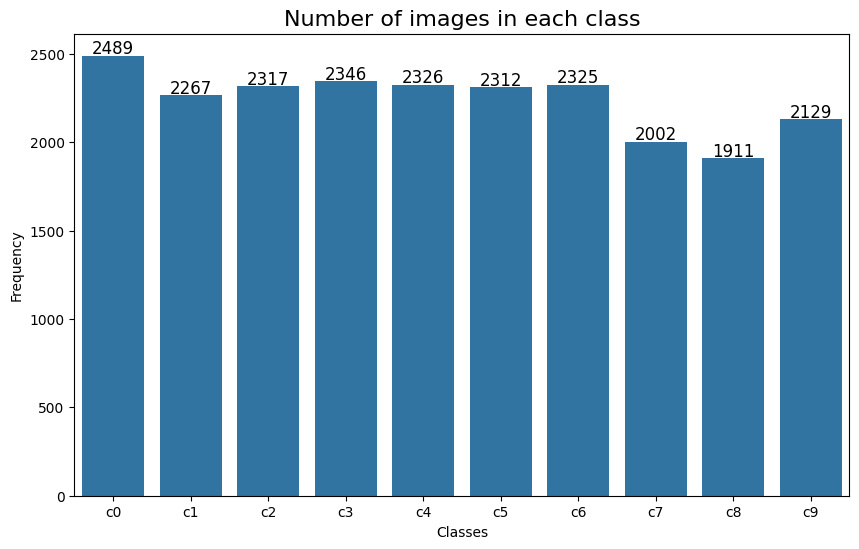

In [10]:
%matplotlib inline

plt.figure(figsize=(10, 6), facecolor=(1, 1, 1))
plots = sns.barplot(x = class_labels, y = class_count)

# plt.xticks()

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 5),
                   textcoords='offset points')

plt.savefig('class_distribution.png', dpi=500, bbox_inches = 'tight')  
    
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Number of images in each class", fontsize=16)
plt.show()

In [11]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

In [12]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [13]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(10,activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 16,814,666
Trainable params: 16,814,666
Non-trainable params: 0
_________________________________________________________________


In [15]:
conv_base.trainable = False

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 16,814,666
Trainable params: 2,099,978
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels = 'inferred',
    validation_split=0.4,
    subset="training",
    seed=42,
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels = 'inferred',
    validation_split=0.4,
    subset="validation",
    seed=42,
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

# validation_ds = keras.utils.image_dataset_from_directory(
#     directory = test_path,
#     labels='inferred',
#     label_mode = 'int',
#     batch_size=32,
#     image_size=(150,150)
# )

Found 22424 files belonging to 10 classes.
Using 13455 files for training.
Found 22424 files belonging to 10 classes.
Using 8969 files for validation.


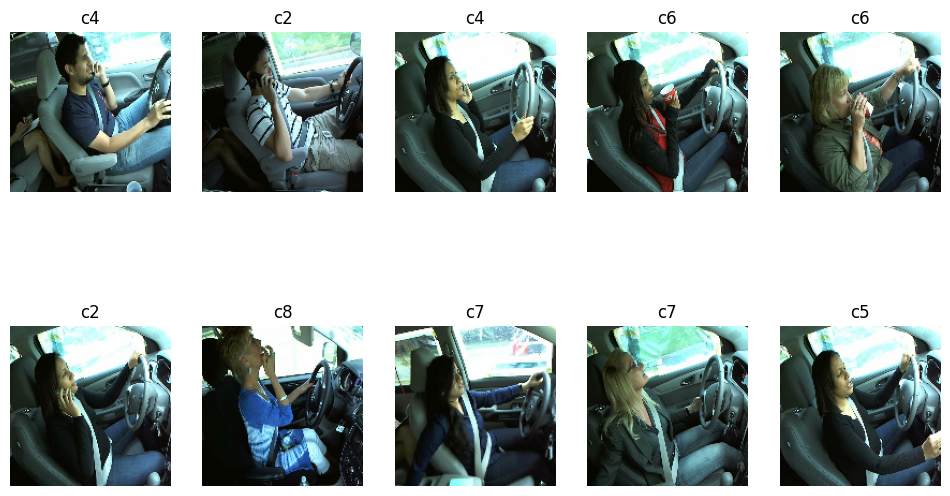

In [18]:
class_names = train_ds.class_names

plt.figure(figsize=(12, 7))
for images, labels in train_ds.take(2):
  for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [20]:
import matplotlib.gridspec as gridspec

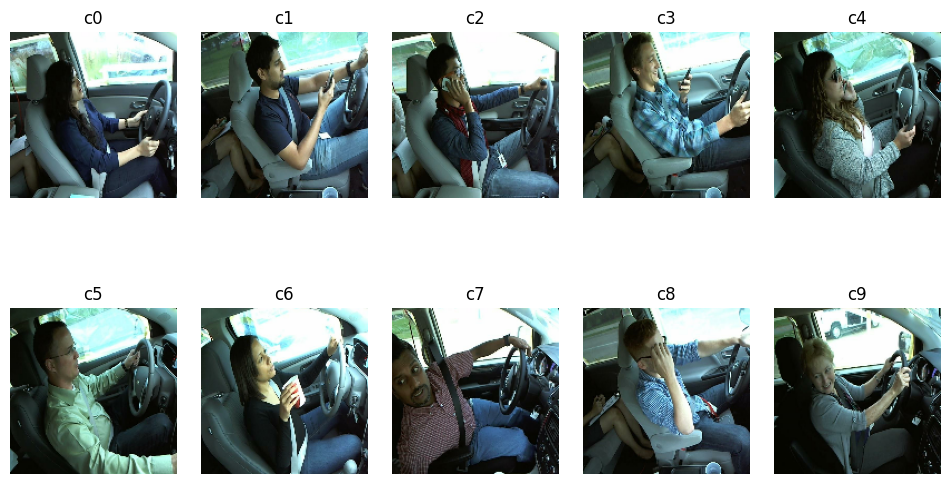

In [32]:
plt.figure(figsize=(12, 7))
gs1 = gridspec.GridSpec(2, 5)
gs1.update(wspace=0.15, hspace=0.05)


for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
#         ax = plt.subplot(2, 5, i+1)
        ax1 = plt.subplot(gs1[i])
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')
        
plt.savefig('class_display_new.png', dpi=500, bbox_inches = 'tight')

In [40]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [41]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [42]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
421/421 [==============================] - 558s 1s/step - loss: 0.4085 - accuracy: 0.8906 - val_loss: 0.1054 - val_accuracy: 0.9747
Epoch 2/10
421/421 [==============================] - 373s 883ms/step - loss: 0.0615 - accuracy: 0.9837 - val_loss: 0.0514 - val_accuracy: 0.9881
Epoch 3/10
421/421 [==============================] - 348s 822ms/step - loss: 0.0221 - accuracy: 0.9955 - val_loss: 0.0532 - val_accuracy: 0.9860
Epoch 4/10
421/421 [==============================] - 345s 819ms/step - loss: 0.0192 - accuracy: 0.9951 - val_loss: 0.0486 - val_accuracy: 0.9866
Epoch 5/10
421/421 [==============================] - 353s 838ms/step - loss: 0.0164 - accuracy: 0.9955 - val_loss: 0.0517 - val_accuracy: 0.9855
Epoch 6/10
421/421 [==============================] - 390s 926ms/step - loss: 0.0242 - accuracy: 0.9918 - val_loss: 0.0756 - val_accuracy: 0.9794
Epoch 7/10
421/421 [==============================] - 395s 938ms/step - loss: 0.0251 - accuracy: 0.9923 - val_loss: 0.0684 - va

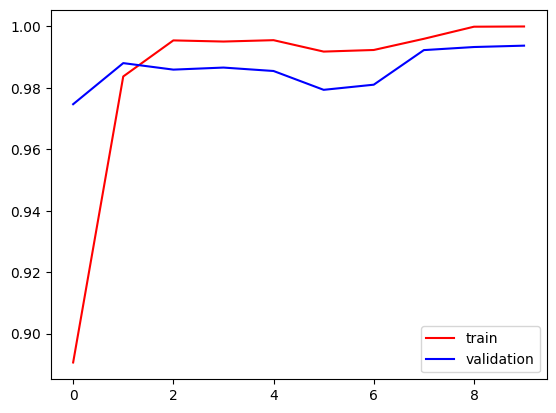

In [43]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

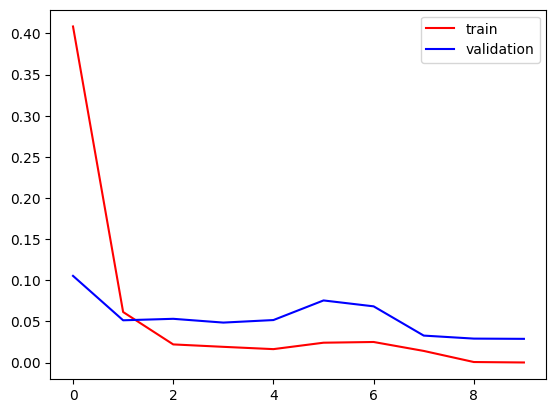

In [44]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()